In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from astroNN.nn.layers import MCDropout
import math
# np.random.seed(0)

### In this notebook, we use a compressed version of JLA compilation
#### First, we load the trained AutoEncoder

In [2]:
np.random.seed(0)

In [3]:
file2 = '../data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))

# shuffle = [x for x in range(len(data.values)) if x%2 == 0]
# comp = [x for x in range(len(data.values)) if x%2 ==1]
# shuffle.extend(comp)
shuffle = [0,1,2,3,4,5,6,7,8,30,28,26,24,22,20,9,10,12,14,16,18,29,27,25,23,21,19,17,15,13,11]

nsize = len(syscov)
# print(data.head(31))
# data.head(31) 
# plt.savefig("DistbinnedJLA.png")
np.shape(syscov)

errors = np.diag(syscov).reshape(nsize,1)
errors = np.where(errors!= 0, np.log(errors), 0)

z = data.values[:,0][shuffle]
dl = data.values[:,1][shuffle]

# FFNN

In [4]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]

# index = np.argsort(z)
zz = np.log10(z)

# scalerz = StandardScaler()
# scalerz.fit(z.reshape(-1, 1))
# zz = scalerz.transform(z.reshape((-1,1)))


scalerdl = StandardScaler()
scalerdl.fit(dl.reshape(-1, 1))
dll = scalerdl.transform(dl.reshape((-1,1)))
# dll = dl.reshape(nsize, 1)


# scalererr = StandardScaler()
# scalererr.fit(errors.reshape(-1, 1))
# errscl = scalererr.transform(errors.reshape((-1,1)))

z_train, z_test = np.split(zz, indx)
y = dll
y_train, y_test = np.split(y, indx)
# y


In [5]:
def model2_dropout(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.001)(efirst)
#     x = Dense(100, activation='relu')(x)
#     x = MCDropout(0.001)(x)
#     x = Dense(150, activation='relu')(x)
#     x = MCDropout(0.001)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [6]:
model2_train = neural_model2.fit(z_train, y_train, batch_size=1,
                                    epochs=1000,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

Epoch 1/1000
24/24 [==============================] - 0s 10ms/step - loss: 1.4470 - val_loss: 0.2503
Epoch 2/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.9244 - val_loss: 0.2974
Epoch 3/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.7064 - val_loss: 0.3463
Epoch 4/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.6808 - val_loss: 0.3359
Epoch 5/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.7873 - val_loss: 0.2898
Epoch 6/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.3891 - val_loss: 0.2326
Epoch 7/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.4292 - val_loss: 0.1903
Epoch 8/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2399 - val_loss: 0.1265
Epoch 9/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.2578 - val_loss: 0.0641
Epoch 10/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.1312 - val_loss: 0.041

24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 2.3409e-04
Epoch 80/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 9.1622e-04
Epoch 81/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 82/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 3.5144e-04
Epoch 83/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 9.8055e-04
Epoch 84/1000
24/24 [==============================] - 0s 1ms/step - loss: 7.5036e-04 - val_loss: 2.1680e-04
Epoch 85/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 5.4992e-04
Epoch 86/1000
24/24 [==============================] - 0s 1ms/step - loss: 8.1223e-04 - val_loss: 2.6339e-04
Epoch 87/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 88/1000
24/24 [==============================] - 0s 1ms/step - 

24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 5.5599e-04
Epoch 157/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 5.1499e-04
Epoch 158/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 5.3638e-04
Epoch 159/1000
24/24 [==============================] - 0s 1ms/step - loss: 9.5788e-04 - val_loss: 0.0011
Epoch 160/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 7.3120e-04
Epoch 161/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 5.1667e-04
Epoch 162/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 3.3014e-04
Epoch 163/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 3.3799e-04
Epoch 164/1000
24/24 [==============================] - 0s 1ms/step - loss: 9.0857e-04 - val_loss: 8.3837e-04
Epoch 165/1000
24/24 [==============================] - 0

24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 2.6754e-04
Epoch 234/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 5.7922e-04
Epoch 235/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 236/1000
24/24 [==============================] - 0s 1ms/step - loss: 2.9961e-04 - val_loss: 0.0012
Epoch 237/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 4.9259e-04
Epoch 238/1000
24/24 [==============================] - 0s 1ms/step - loss: 8.8624e-04 - val_loss: 7.3554e-04
Epoch 239/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 6.8090e-04
Epoch 240/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 241/1000
24/24 [==============================] - 0s 1ms/step - loss: 9.5067e-04 - val_loss: 5.9687e-04
Epoch 242/1000
24/24 [==============================] - 0s 1m

Epoch 310/1000
24/24 [==============================] - 0s 1ms/step - loss: 6.4378e-04 - val_loss: 6.3844e-04
Epoch 311/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 3.6349e-04
Epoch 312/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 3.4723e-04
Epoch 313/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 4.8047e-04
Epoch 314/1000
24/24 [==============================] - 0s 1ms/step - loss: 6.0105e-04 - val_loss: 4.1642e-04
Epoch 315/1000
24/24 [==============================] - 0s 1ms/step - loss: 5.7893e-04 - val_loss: 7.9085e-04
Epoch 316/1000
24/24 [==============================] - 0s 1ms/step - loss: 9.9638e-04 - val_loss: 3.4746e-04
Epoch 317/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 318/1000
24/24 [==============================] - 0s 1ms/step - loss: 7.7603e-04 - val_loss: 7.7120e-04
Epoch 319/1000
24/24 [========

24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 3.3058e-04
Epoch 388/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 389/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 3.1639e-04
Epoch 390/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 391/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 3.0814e-04
Epoch 392/1000
24/24 [==============================] - 0s 1ms/step - loss: 9.2901e-04 - val_loss: 0.0017
Epoch 393/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 394/1000
24/24 [==============================] - 0s 1ms/step - loss: 8.9565e-04 - val_loss: 6.2269e-04
Epoch 395/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 4.9148e-04
Epoch 396/1000
24/24 [==============================] - 0s 1ms/step -

Epoch 465/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 6.5915e-04
Epoch 466/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 7.5104e-04
Epoch 467/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 5.3150e-04
Epoch 468/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 7.8781e-04
Epoch 469/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 470/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 4.8134e-04
Epoch 471/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 472/1000
24/24 [==============================] - 0s 1ms/step - loss: 7.3069e-04 - val_loss: 5.7580e-04
Epoch 473/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 5.2077e-04
Epoch 474/1000
24/24 [============================

24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 543/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 5.9820e-04
Epoch 544/1000
24/24 [==============================] - 0s 1ms/step - loss: 6.9709e-04 - val_loss: 4.9054e-04
Epoch 545/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 546/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 6.6644e-04
Epoch 547/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 7.5394e-04
Epoch 548/1000
24/24 [==============================] - 0s 1ms/step - loss: 7.3928e-04 - val_loss: 2.9780e-04
Epoch 549/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 550/1000
24/24 [==============================] - 0s 1ms/step - loss: 6.9259e-04 - val_loss: 6.2970e-04
Epoch 551/1000
24/24 [==============================] - 0s 1m

24/24 [==============================] - 0s 1ms/step - loss: 5.7826e-04 - val_loss: 6.5082e-04
Epoch 620/1000
24/24 [==============================] - 0s 1ms/step - loss: 7.1357e-04 - val_loss: 5.5808e-04
Epoch 621/1000
24/24 [==============================] - 0s 1ms/step - loss: 8.6677e-04 - val_loss: 0.0015
Epoch 622/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 623/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 5.5006e-04
Epoch 624/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 6.7245e-04
Epoch 625/1000
24/24 [==============================] - 0s 1ms/step - loss: 8.5469e-04 - val_loss: 5.9502e-04
Epoch 626/1000
24/24 [==============================] - 0s 1ms/step - loss: 5.7719e-04 - val_loss: 0.0012
Epoch 627/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 6.8823e-04
Epoch 628/1000
24/24 [==============================]

24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 4.8330e-04
Epoch 697/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 6.0516e-04
Epoch 698/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 4.3941e-04
Epoch 699/1000
24/24 [==============================] - 0s 1ms/step - loss: 8.2572e-04 - val_loss: 4.7459e-04
Epoch 700/1000
24/24 [==============================] - 0s 1ms/step - loss: 8.5997e-04 - val_loss: 3.6479e-04
Epoch 701/1000
24/24 [==============================] - 0s 1ms/step - loss: 4.9814e-04 - val_loss: 0.0012
Epoch 702/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 8.0100e-04
Epoch 703/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 8.6939e-04
Epoch 704/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 705/1000
24/24 [==============================] - 0

24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 8.1448e-04
Epoch 774/1000
24/24 [==============================] - 0s 1ms/step - loss: 4.3131e-04 - val_loss: 0.0017
Epoch 775/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 5.1755e-04
Epoch 776/1000
24/24 [==============================] - 0s 1ms/step - loss: 4.7993e-04 - val_loss: 8.6346e-04
Epoch 777/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 5.3635e-04
Epoch 778/1000
24/24 [==============================] - 0s 1ms/step - loss: 9.7101e-04 - val_loss: 5.7542e-04
Epoch 779/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 780/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 781/1000
24/24 [==============================] - 0s 1ms/step - loss: 8.5612e-04 - val_loss: 5.4817e-04
Epoch 782/1000
24/24 [==============================] - 0

24/24 [==============================] - 0s 1ms/step - loss: 4.9681e-04 - val_loss: 4.0033e-04
Epoch 851/1000
24/24 [==============================] - 0s 1ms/step - loss: 8.1347e-04 - val_loss: 6.1687e-04
Epoch 852/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 853/1000
24/24 [==============================] - 0s 1ms/step - loss: 9.9961e-04 - val_loss: 6.5047e-04
Epoch 854/1000
24/24 [==============================] - 0s 1ms/step - loss: 9.8409e-04 - val_loss: 0.0013
Epoch 855/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 856/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 2.9370e-04
Epoch 857/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 9.5845e-04
Epoch 858/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 859/1000
24/24 [==============================] - 0s 1m

Epoch 927/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 9.3450e-04
Epoch 928/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 929/1000
24/24 [==============================] - 0s 1ms/step - loss: 6.4736e-04 - val_loss: 8.7002e-04
Epoch 930/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 7.2171e-04
Epoch 931/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 932/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 933/1000
24/24 [==============================] - 0s 1ms/step - loss: 5.6391e-04 - val_loss: 0.0014
Epoch 934/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 9.6514e-04
Epoch 935/1000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 4.0918e-04
Epoch 936/1000
24/24 [==============================] 

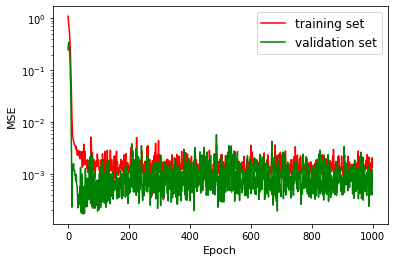

In [7]:
# plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.yscale('log')
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
# plt.xticks([])
# plt.yticks([])
# plt.title('FFNN+MC-DO', fontsize=8)

plt.savefig('loss_dropoutJLA2.png')

In [8]:
# file3 = 'fake_binned_JLA2TEST3new.dat'
# data3 = np.loadtxt(file3, skiprows=3)

# z_test = data3[:,0]
z_test = zz
# z_test = np.log10(np.linspace(0.01,1.3,1000))
# x_test

In [9]:
test_batch_size = len(z_test)
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
# x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 100# Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))

for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(z_test)
    

prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)

# get mean results and its varience
# pred_err = np.exp(pred_random[:,1].reshape(-1,1))
# pred_err = np.exp(pred_random[:,1].reshape(-1,1))


# sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)




In [10]:
# predictions_err

In [11]:
Om = 0.27
# variance network
w0 = -1

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
#     return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa):
#         if model == 'lcdm':
#             return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
#         elif model == 'owacdm':
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, w0=-1, wa=0.0):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, w0, wa)*(1+z))+43



In [12]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
    fowacdm1.append(distance_modulus(zzz, w0=-10, wa=-100))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

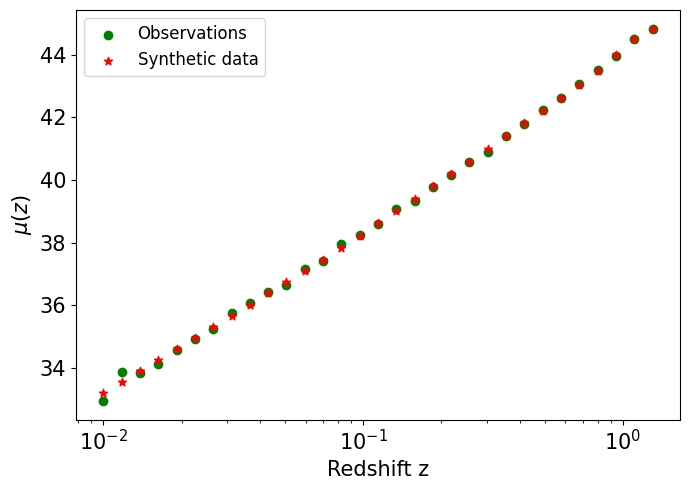

In [13]:
plt.figure(figsize=(7, 5), dpi=100)

# Plotting
dlfake = scalerdl.inverse_transform(prediction_mc_dropout.reshape(-1,1))[:,0]
# dlfake = prediction_mc_dropout[:,0]
# plt.figure(figsize=(10, 7), dpi=100)

# fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
# sigma = np.sqrt(std_mc_dropout.reshape(31,))

plt.scatter(z, dl, c='g', label='Observations')
# plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.scatter(10**z_test, dlfake, marker='*', c='r', label='Synthetic data')

# plt.errorbar(x_test, dlfake, yerr=sigma
#              , markersize=10, fmt='.', 
#              ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='r',
#              label='Synthetic data')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(zmodel, fowacdm1, label='CPL $w_0 = -1.3, w_a=1.2$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
# plt.xlim(-0.01, np.max(z)+0.2)
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
# plt.xlim(0, np.max(z))
plt.xticks(fontsize=15)
# plt.text(0.6, 45, 'FFNN+MC-DO', fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')

plt.tight_layout()
plt.legend(loc='upper left', fontsize=12)
# plt.show()
plt.savefig('DL_dropoutb2.png')

In [14]:
index = np.argsort(z_test)
fake_data2 = np.stack((z[index], dlfake[index]), axis=1)


# np.savetxt("fake_binned_JLADO2.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

In [15]:
tf.keras.models.save_model(neural_model2, '../models/FFNN_JLA_DO.h5' )